In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if gc > 0: x[i] = np.random.normal(0, sk[gc])
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
p = 2000
k = 3
sparsity = 0.8
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)

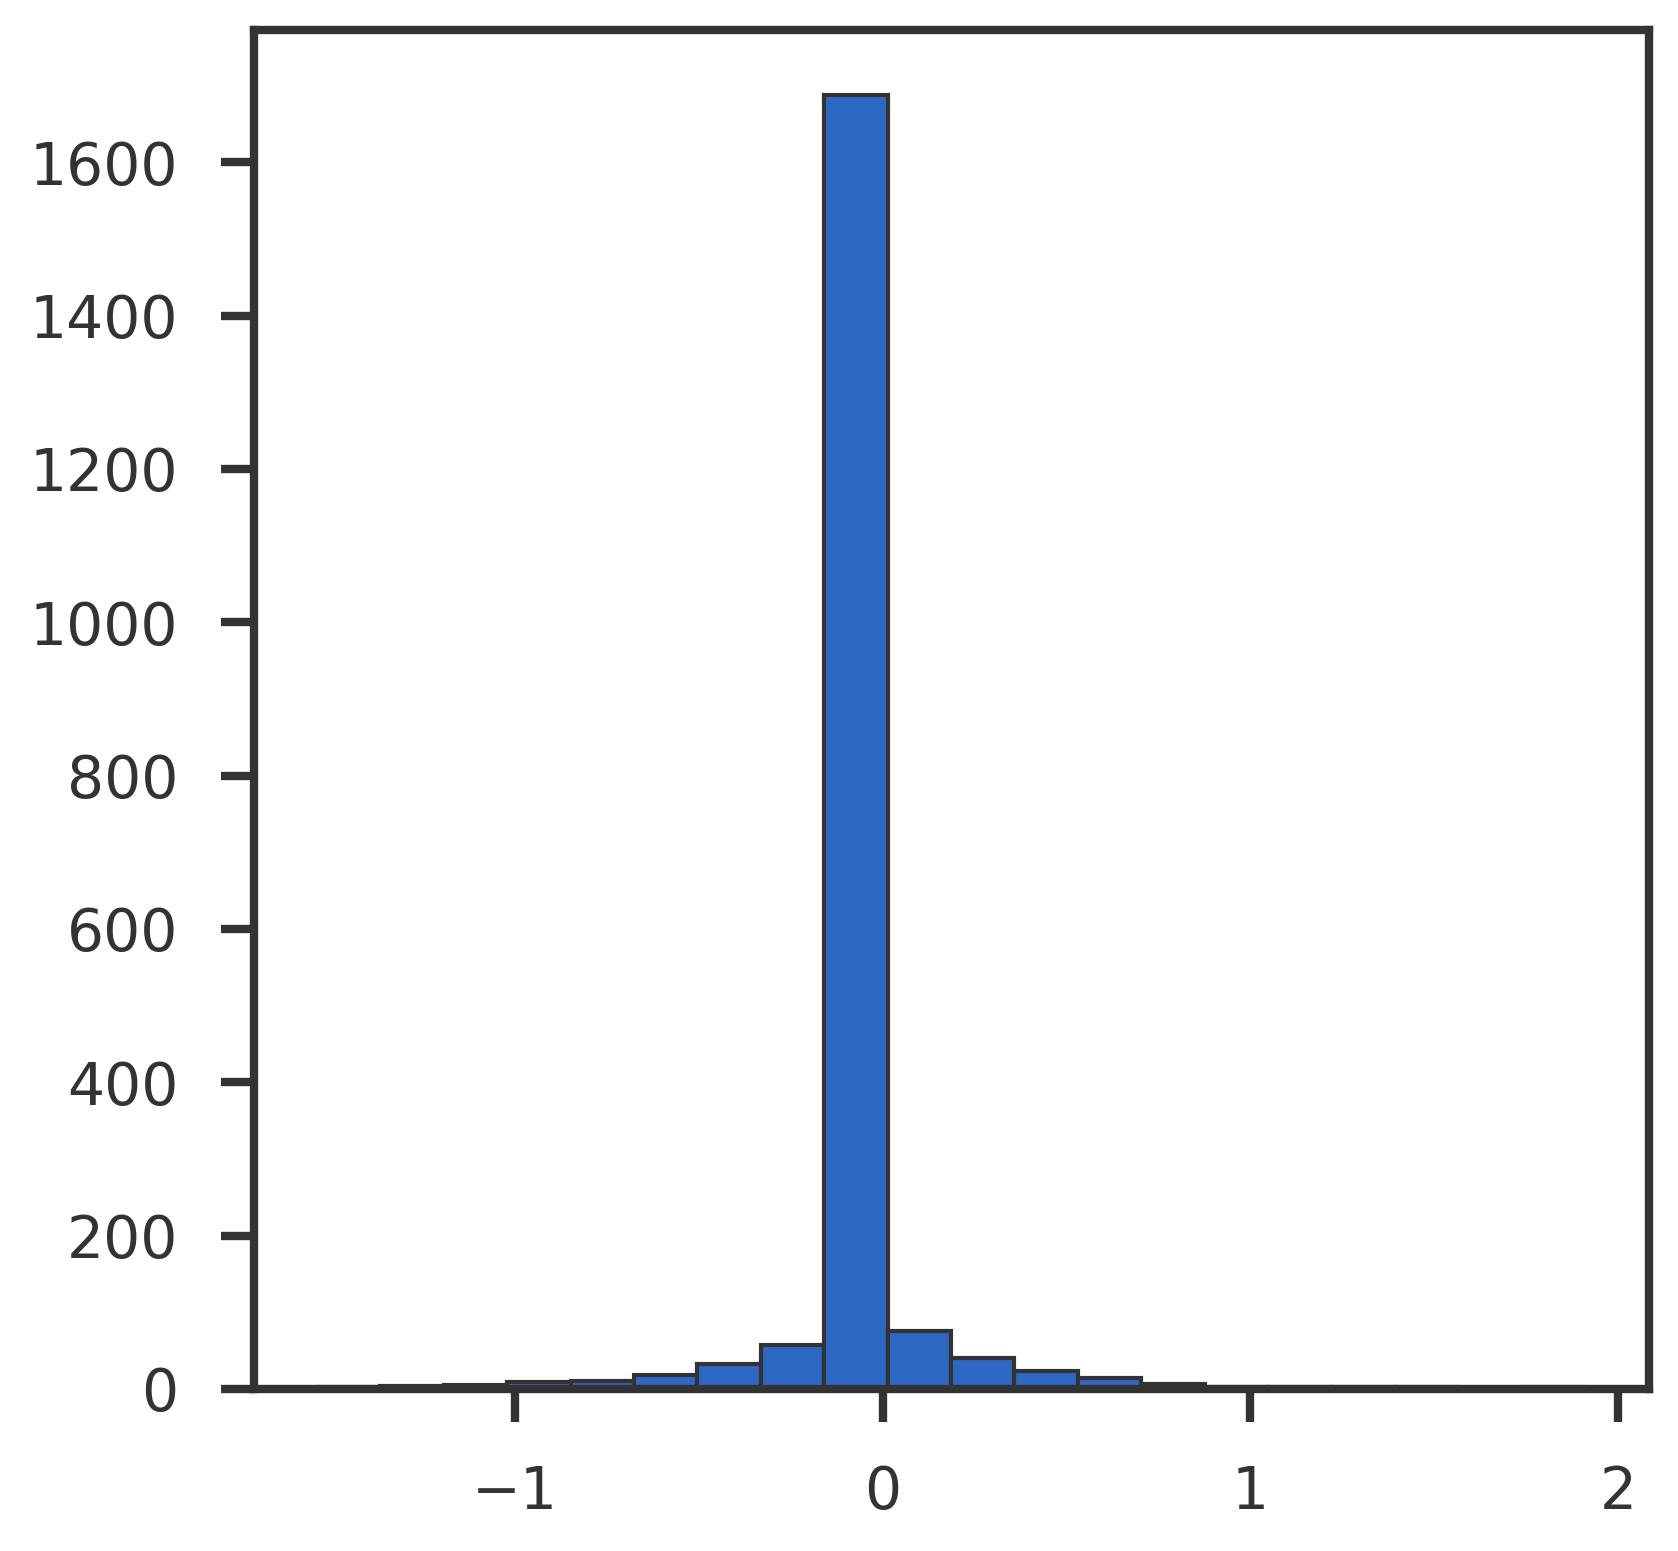

In [4]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.hist(btrue)
#ax1.hist(mean)
plt.show()

In [5]:
dj = np.ones(p)

In [6]:
def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

In [7]:
z_newraph = unshrink_b(btrue, strue, wtrue, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, wtrue, sk, dj)
objtrue   = penalty_operator(z_newraph, wtrue, strue, sk, dj)

1872.1511705134094
12648.146993394119
2012.074594321858
3356.7312347150523
2101.11645775907
2730.429647350532
2205.5568800916644
2260.875394633147
2239.450493723516
2237.7794872439554
2237.760861930462


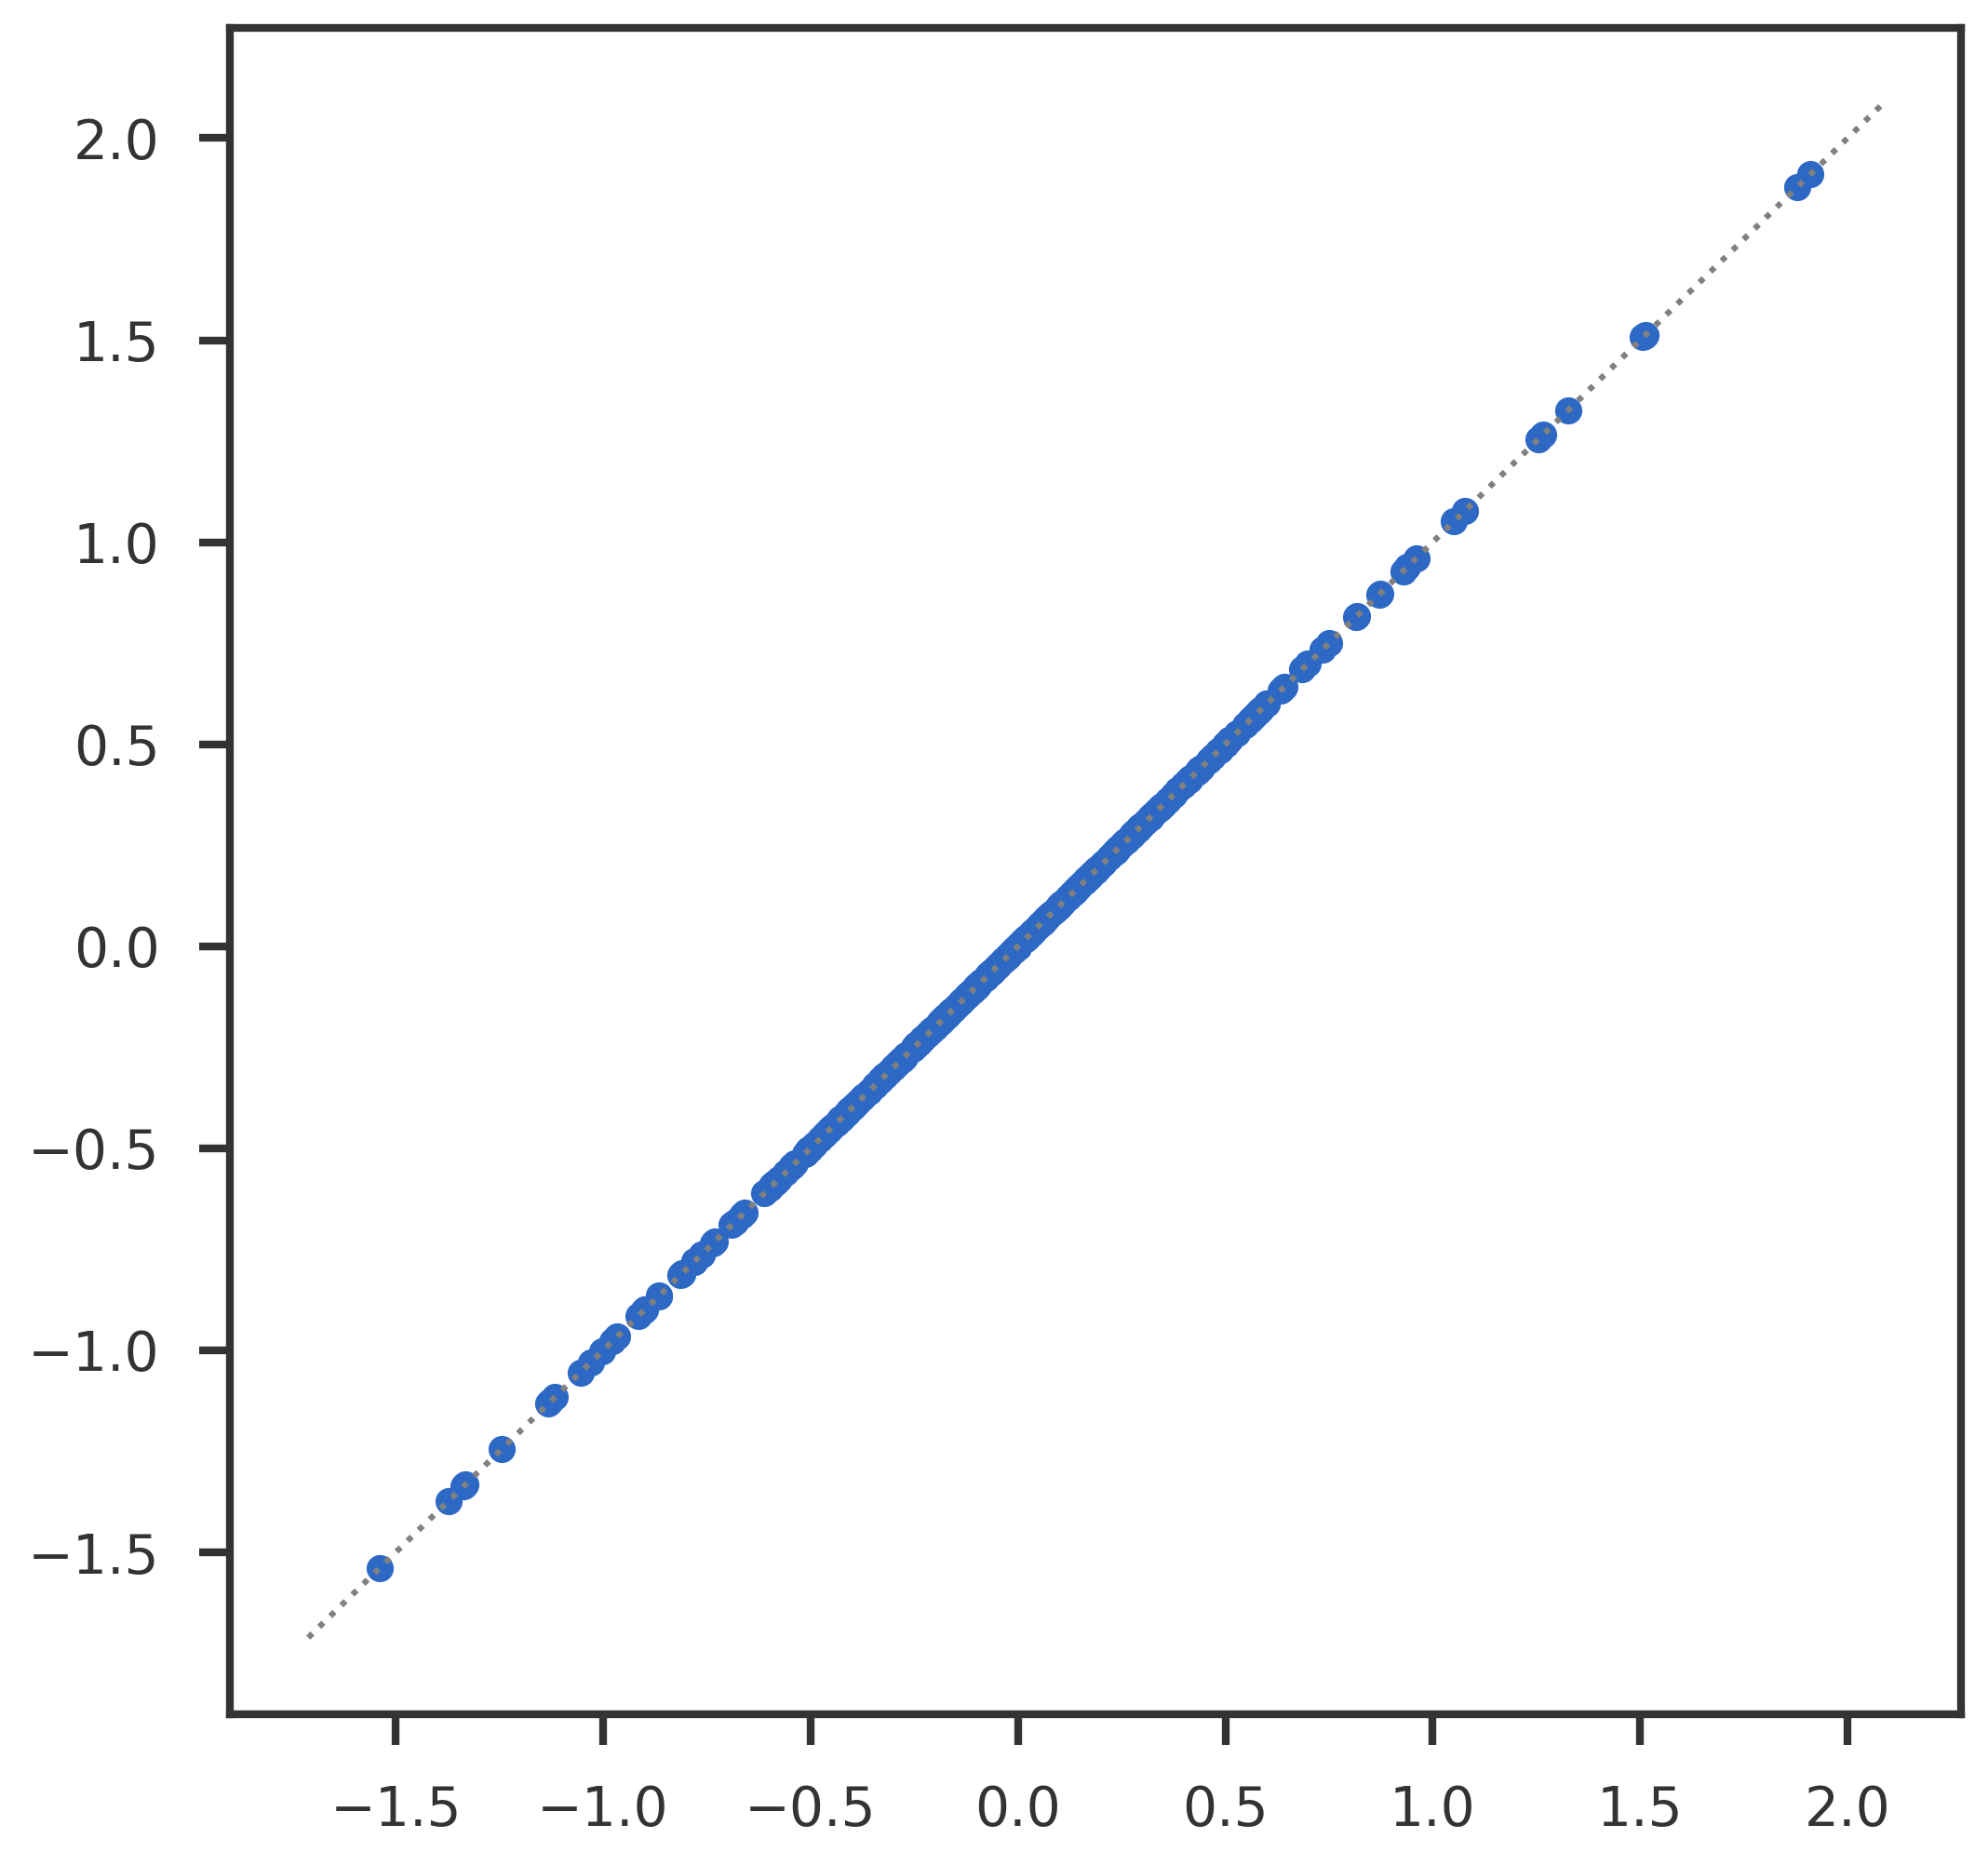

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, b_newraph)
mpl_utils.plot_diag(ax1)

In [9]:
np.sum(objtrue)

2237.760858910424

In [10]:
winit, _ = initialize_ash_prior(k)
objinit = penalty_operator(z_newraph, winit, strue, sk, dj)
print(np.sum(objinit))

2408.8190917811025


In [11]:
btrue[btrue != 0].shape

(377,)

In [12]:
wtrue

array([0.8, 0.1, 0.1])